In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

from astrobee_strips import STRIPS, Node, Queue, get_plan

from sys import path
path.append('/home/acauligi/Software')

import pdb
import numpy as np
from casadi import *

# STRIPS planner

In [2]:
strip = STRIPS()
n0 = Node(strip)
qq = Queue()
qq.queue(n0)

operators = ['dock_objA_dockA', 'dock_objA_dockB', 'dock_objA_dockC', \
            'dock_objB_dockA', 'dock_objB_dockB', 'dock_objB_dockC', \
            'undock_objA_dockA', 'undock_objA_dockB', 'undock_objA_dockC', \
            'undock_objB_dockA', 'undock_objB_dockB', 'undock_objB_dockC', \
            'grasp_objA', 'grasp_objB']

max_depth = 5

In [3]:
while not qq.is_empty():
    if all([node.depth >= max_depth for node in qq.list]):
        print('Max depth violated')
        break

    leaf_node = qq.dequeue()
    for operator in operators:
        new_leaf = leaf_node.act(operator)
        if all(new_leaf.strip.state == leaf_node.strip.state):
            continue
        qq.queue(new_leaf)

    if any([node.solved for node in qq.list]):
        print('solved')
        break

solved


In [4]:
solved_node = [node for node in qq.list if node.solved][0]
plan = get_plan(solved_node)
plan

['undock_objA_dockB', 'dock_objA_dockA', 'grasp_objB', 'dock_objB_dockB']

# TAMP Class


In [5]:
from astrobee_tamp import AstrobeeTAMP

mode = 'double_integrator'

if mode == 'nonlinear':
    Xi = np.array([3.,3.,3., 0.,0.,0.,1., 0.05,-0.05,0.02, 0.01,-0.01,0.01])
    Xref = DM([0.,0.1,0., 0.5,0.5,0.5,0.5, 0.,0.,0., 0.,0.,0.])
elif mode == 'double_integrator':
    Xi = np.array([3.,3., 0., 0.])
    Xref = DM([0.,0.1, 0., 0.])

at = AstrobeeTAMP(Xi, Xref, mode=mode)

at.plan = plan
print(plan)

['undock_objA_dockB', 'dock_objA_dockA', 'grasp_objB', 'dock_objB_dockB']


In [6]:
at.unroll_plan()

at.construct_problem()
at.solve_problem()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1160
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      134

Total number of variables............................:      316
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      198
                     variables with only upper bounds:        0
Total number of equa

True

In [20]:
# at.soln['f']
# at.soln['x'].shape
# len(plan)
# len(at.X)
# len(at.U)

# at.dock_loc
at.soln['x'].shape
at.soln['x'][:4]

N_plan = len(at.plan) * at.N
X_prev, U_prev = np.zeros((at.n, N_plan)), np.zeros((at.m, N_plan))

idx = 0
for n in range(N_plan):
    X_prev[:,n] = at.soln['x'][idx:idx+at.n].elements()
    idx += at.n
for n in range(N_plan):
    U_prev[:,n] = at.soln['x'][idx:idx+at.m].elements()
    idx += at.m

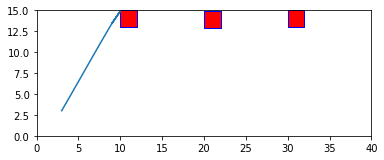

<Figure size 432x288 with 0 Axes>

In [30]:
dock_w, dock_h = 2., 2.

plt.axes()

for (k,dock_loc) in at.dock_loc.items():
    rectangle = plt.Rectangle((dock_loc[0], dock_loc[1]-dock_h), \
                              dock_w, dock_h, \
                             fc='red', ec='blue')
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')

plt.plot(X_prev[0,:], X_prev[1,:])

posmin, posmax = np.array([0.,0.]), np.array([40.,15.])
ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))


fig = plt.figure()
plt.show()

In [32]:
X_prev[1,:]

array([ 3.        ,  3.26487647,  4.01020155,  5.13306085,  6.52144815,
        8.05392115,  9.60223514, 11.03817068, 12.24018334, 13.09578271,
       13.50117031, 13.65653974, 13.81191891, 13.96731232, 14.1227227 ,
       14.27815101, 14.43359644, 14.58905636, 14.74452631, 14.9       ,
       14.98469945, 14.9420427 , 14.8004085 , 14.58815883, 14.333631  ,
       14.06513234, 13.81093619, 13.59927775, 13.45834828, 13.41628706,
       13.50117031, 13.65653974, 13.81191891, 13.96731232, 14.1227227 ,
       14.27815101, 14.43359644, 14.58905636, 14.74452631, 14.9       ])